In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-09-08 11:04:14.943424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 11:04:14.943533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 11:04:15.074017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [4]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [5]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.5)

validate_set = test_datagen.flow_from_directory(
       test_set_directory,
       class_mode = "categorical",
       target_size = (SIZE_X, SIZE_Y),
       color_mode="rgb",
       batch_size = 128, 
       shuffle = False,
       subset='training',
       seed = 42)


test_set = test_datagen.flow_from_directory(
    test_set_directory,
    class_mode='categorical',
    target_size=(SIZE_X, SIZE_Y),
    color_mode='rgb',
    batch_size=128,
    subset='validation',
    shuffle=False  # No shuffling needed for testing
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [6]:
# For train set
train_class_indices = train_set.class_indices
train_classes = train_set.classes
train_class_counts = {class_name: 0 for class_name in train_class_indices.keys()}

for class_index in train_classes:
    class_name = list(train_class_indices.keys())[list(train_class_indices.values()).index(class_index)]
    train_class_counts[class_name] += 1

print("Training set class distribution:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

# For validation set
val_class_indices = validate_set.class_indices
val_classes = validate_set.classes
val_class_counts = {class_name: 0 for class_name in val_class_indices.keys()}

for class_index in val_classes:
    class_name = list(val_class_indices.keys())[list(val_class_indices.values()).index(class_index)]
    val_class_counts[class_name] += 1

print("\nValidation set class distribution:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} images")

# For test set
test_class_indices = test_set.class_indices
test_classes = test_set.classes
test_class_counts = {class_name: 0 for class_name in test_class_indices.keys()}

for class_index in test_classes:
    class_name = list(test_class_indices.keys())[list(test_class_indices.values()).index(class_index)]
    test_class_counts[class_name] += 1

print("\nTest set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")


Training set class distribution:
lung_aca: 4000 images
lung_n: 4000 images
lung_scc: 4000 images

Validation set class distribution:
lung_aca: 500 images
lung_n: 500 images
lung_scc: 500 images

Test set class distribution:
lung_aca: 500 images
lung_n: 500 images
lung_scc: 500 images


In [7]:
IMAGE_SIZE = [224, 224]

# Resnet50

In [8]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
    

In [10]:
flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)

In [11]:
#creating a model
model = Model(inputs = resnet.input, outputs = prediction )

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,311,363 (188.11 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# COMPILING THE MODEL
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [14]:
batch_size = 128

# Resnet50 training

In [15]:
history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725793585.923201     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725793585.978360     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/94 ━━━━━━━━━━━━━━━━━━━━ 26s 526ms/step - accuracy: 0.5261 - loss: 56.7336

W0000 00:00:1725793627.042487     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6439 - loss: 35.4236

W0000 00:00:1725793657.740146     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6456 - loss: 35.1809 - val_accuracy: 0.8960 - val_loss: 0.8793
Epoch 2/5


W0000 00:00:1725793680.504548     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 580ms/step - accuracy: 0.9313 - loss: 0.7490 - val_accuracy: 0.9680 - val_loss: 0.1964
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 568ms/step - accuracy: 0.9718 - loss: 0.2229 - val_accuracy: 0.9800 - val_loss: 0.0734
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 587ms/step - accuracy: 0.9887 - loss: 0.0437 - val_accuracy: 0.9833 - val_loss: 0.0539
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 597ms/step - accuracy: 0.9972 - loss: 0.0061 - val_accuracy: 0.9827 - val_loss: 0.0655


In [16]:
def loss_curve(history):
    plt.plot(history.history['loss'],label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'testing_loss')
    plt.title('loss')
    plt.legend()
    plt.show()
    

def accuracy_curve(history):
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [18]:
def reports(model,test_set):
    from sklearn.metrics import confusion_matrix
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred ,axis =1)
    print('Confusion Matrix')
    confusion_matrix = confusion_matrix(test_set.classes, y_pred)
    print(confusion_matrix)
    print('Classification Report')
    target_names = ['aca','n', 'scc']
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

# Resnet50 results

In [19]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 603ms/step - accuracy: 0.9849 - loss: 0.0604
test_loss, test accuracy [0.07848646491765976, 0.9793333411216736]


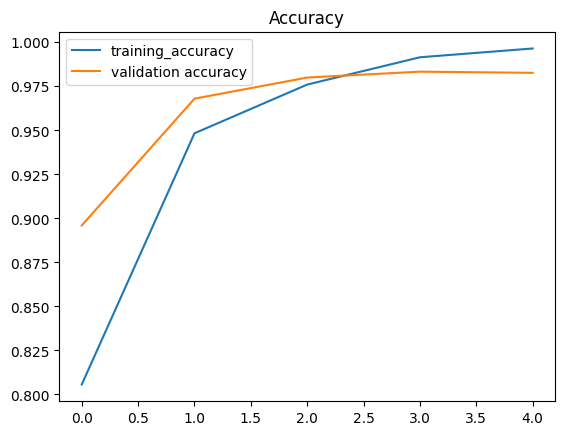

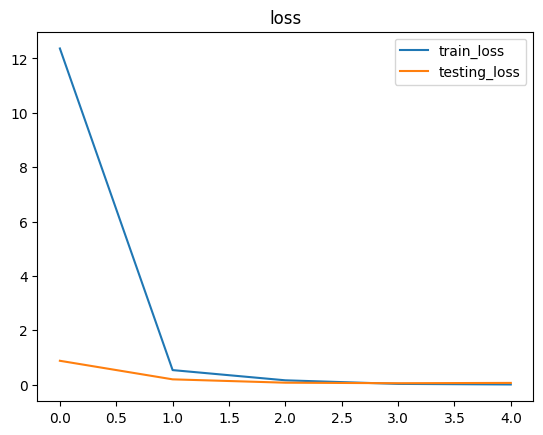

 1/12 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step

W0000 00:00:1725793932.119313     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 829ms/step


W0000 00:00:1725793941.240616     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[490   4   6]
 [  0 500   0]
 [ 21   0 479]]
Classification Report
              precision    recall  f1-score   support

         aca       0.96      0.98      0.97       500
           n       0.99      1.00      1.00       500
         scc       0.99      0.96      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [20]:
accuracy_curve(history)
loss_curve(history)
reports(model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step


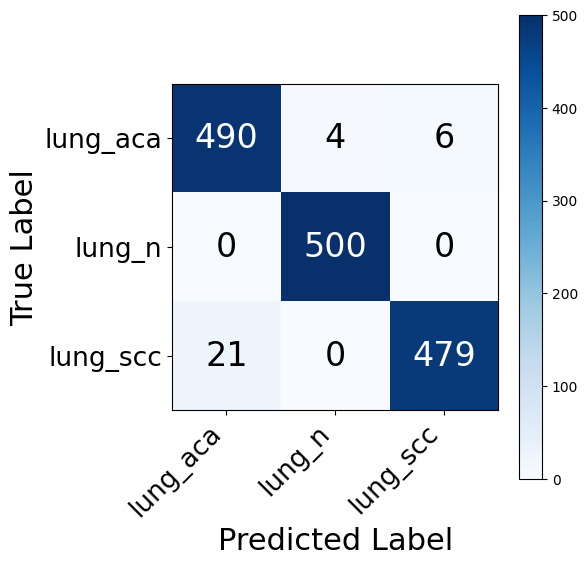

In [21]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# Resnet101

In [22]:
resnet101 = ResNet101(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
resnet=resnet101

In [24]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [25]:
flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)

In [26]:
#creating a model
model = Model(inputs = resnet.input, outputs = prediction )

In [27]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 68,381,827 (260.86 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [28]:
# COMPILING THE MODEL
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Resnet101 training

In [29]:
history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


W0000 00:00:1725793978.226551     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/94 ━━━━━━━━━━━━━━━━━━━━ 23s 622ms/step - accuracy: 0.5607 - loss: 23.3778

W0000 00:00:1725794018.394067     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6463 - loss: 16.9184

W0000 00:00:1725794049.219689     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725794058.701596     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 105s 864ms/step - accuracy: 0.6480 - loss: 16.7996 - val_accuracy: 0.9107 - val_loss: 0.6668
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 676ms/step - accuracy: 0.9301 - loss: 0.9014 - val_accuracy: 0.9507 - val_loss: 0.2916
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 672ms/step - accuracy: 0.9007 - loss: 1.9151 - val_accuracy: 0.9427 - val_loss: 0.3816
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 668ms/step - accuracy: 0.9734 - loss: 0.1288 - val_accuracy: 0.9767 - val_loss: 0.1433
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 667ms/step - accuracy: 0.9881 - loss: 0.0330 - val_accuracy: 0.9673 - val_loss: 0.1391


# Resnet101 Evaluation

In [30]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 581ms/step - accuracy: 0.9428 - loss: 0.2257
test_loss, test accuracy [0.12427768856287003, 0.968666672706604]


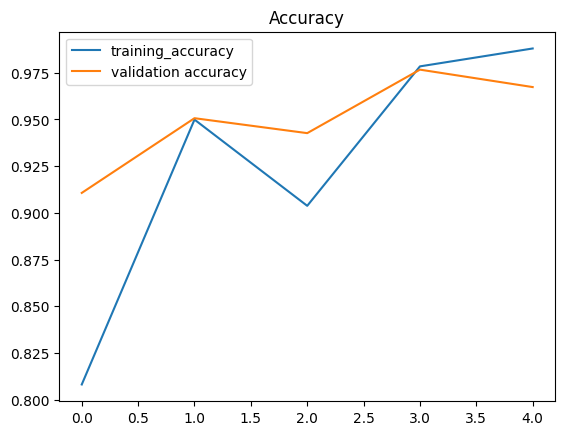

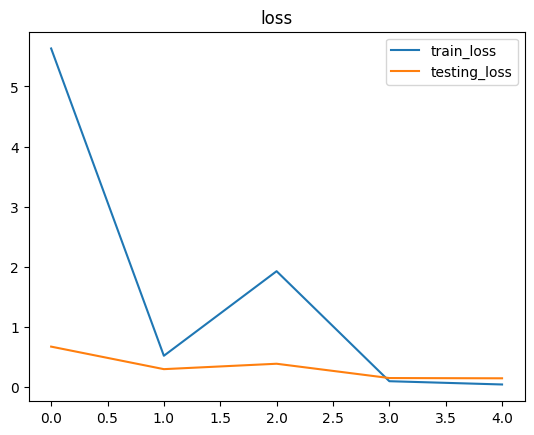

 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:35 9s/step

W0000 00:00:1725794346.198622     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 


W0000 00:00:1725794359.117799     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[456   5  39]
 [  0 500   0]
 [  3   0 497]]
Classification Report
              precision    recall  f1-score   support

         aca       0.99      0.91      0.95       500
           n       0.99      1.00      1.00       500
         scc       0.93      0.99      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [31]:
accuracy_curve(history)
loss_curve(history)
reports(model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 562ms/step


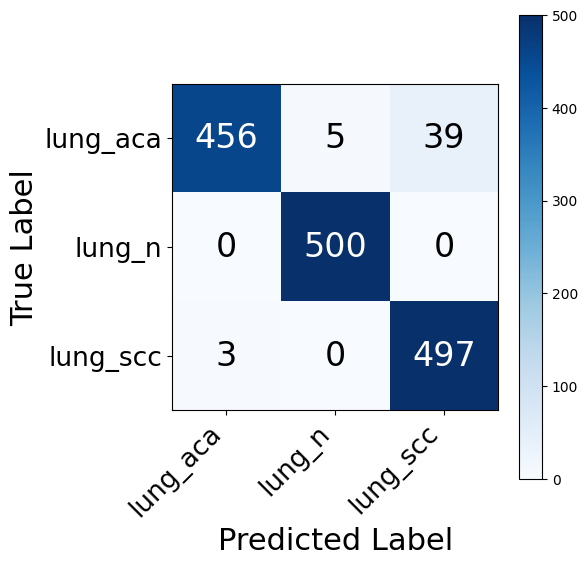

In [32]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# EfficientNetB0

In [33]:
from tensorflow.keras.applications import EfficientNetB0

In [34]:
enb0 = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enb0.layers:
        layer.trainable = False

# Add new layers
flatten = Flatten()(enb0.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
# Create the model
model = Model(inputs=enb0.input, outputs=prediction)

# Print the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 20,139,430 (76.83 MB)

 Trainable params: 16,089,859 (61.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [36]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# EfficientNetB0 training

In [37]:
history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5
 1/94 ━━━━━━━━━━━━━━━━━━━━ 1:16:09 49s/step - accuracy: 0.0938 - loss: 1.3661

W0000 00:00:1725794419.972799     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/94 ━━━━━━━━━━━━━━━━━━━━ 26s 984ms/step - accuracy: 0.6626 - loss: 4.1916

W0000 00:00:1725794484.930589     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.7058 - loss: 3.4737

W0000 00:00:1725794503.529098     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7071 - loss: 3.4531 - val_accuracy: 0.9100 - val_loss: 0.2726
Epoch 2/5


W0000 00:00:1725794525.244769     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 562ms/step - accuracy: 0.8923 - loss: 0.7958 - val_accuracy: 0.9613 - val_loss: 0.1079
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 558ms/step - accuracy: 0.9653 - loss: 0.0916 - val_accuracy: 0.9773 - val_loss: 0.0631
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 560ms/step - accuracy: 0.9845 - loss: 0.0476 - val_accuracy: 0.9647 - val_loss: 0.0886
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 572ms/step - accuracy: 0.9768 - loss: 0.0582 - val_accuracy: 0.9740 - val_loss: 0.0549


# EfficientNetB0 Evaluation

In [38]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.9531 - loss: 0.1097
test_loss, test accuracy [0.05857885628938675, 0.9753333330154419]


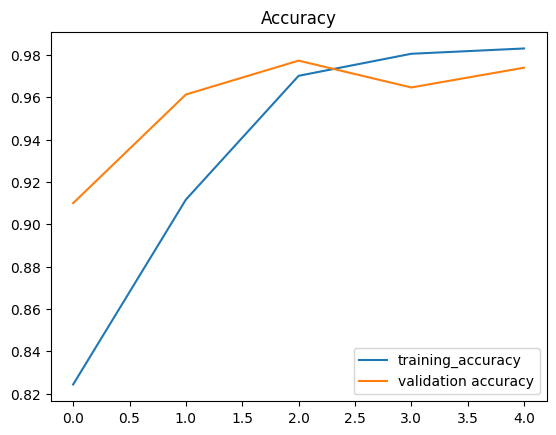

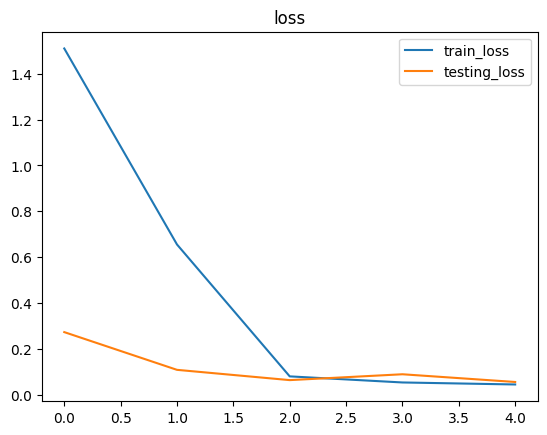

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step

W0000 00:00:1725794769.426238     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
Confusion Matrix
[[464   1  35]
 [  1 499   0]
 [  0   0 500]]
Classification Report
              precision    recall  f1-score   support

         aca       1.00      0.93      0.96       500
           n       1.00      1.00      1.00       500
         scc       0.93      1.00      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



W0000 00:00:1725794781.168393     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [39]:
accuracy_curve(history)
loss_curve(history)
reports(model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 512ms/step


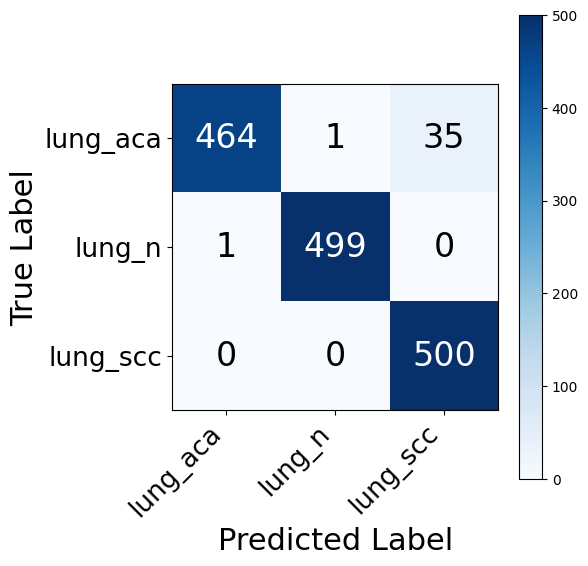

In [40]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# EfficientNetB3

In [41]:
from tensorflow.keras.applications import EfficientNetB3

In [42]:
efficientnetb3 = EfficientNetB3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [43]:
# Freeze the base model layers
for layer in efficientnetb3.layers:
    layer.trainable = False

In [44]:
# Add new layers
flatten = Flatten()(efficientnetb3.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

In [45]:
# Create the model
model = Model(inputs=efficientnetb3.input, outputs=prediction)

# Print the model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 30,084,658 (114.76 MB)

 Trainable params: 19,301,123 (73.63 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [46]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# EfficientNetB3 Training

In [47]:
history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


W0000 00:00:1725794878.557365     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/94 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6472 - loss: 12.1579   

W0000 00:00:1725794966.023834     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6960 - loss: 9.8722

W0000 00:00:1725794989.497915     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.6972 - loss: 9.8168 - val_accuracy: 0.9360 - val_loss: 0.5850
Epoch 2/5


W0000 00:00:1725795020.000341     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 0.9164 - loss: 0.9293 - val_accuracy: 0.9727 - val_loss: 0.0883
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.9584 - loss: 0.1509 - val_accuracy: 0.9667 - val_loss: 0.0880
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 596ms/step - accuracy: 0.9777 - loss: 0.0636 - val_accuracy: 0.9793 - val_loss: 0.0637
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.9829 - loss: 0.0514 - val_accuracy: 0.9787 - val_loss: 0.0671


# EfficientNetB3 evaluation

In [48]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.9699 - loss: 0.0812
test_loss, test accuracy [0.05242350324988365, 0.9806666374206543]


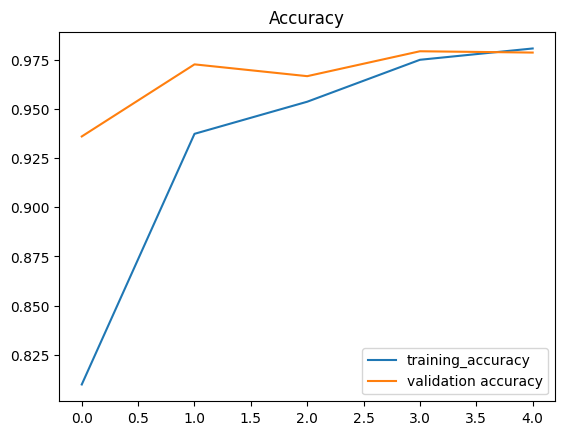

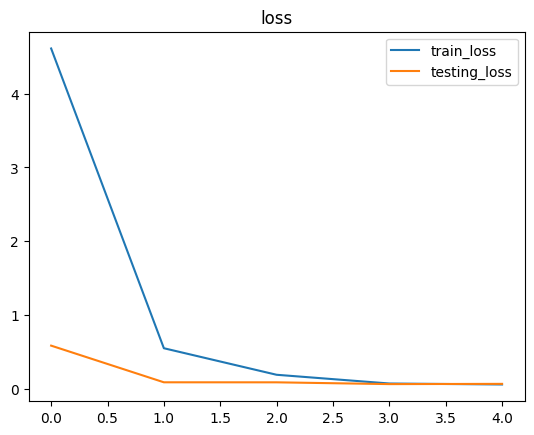

 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:40 9s/step

W0000 00:00:1725795274.836483     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 
Confusion Matrix
[[476   1  23]
 [  1 499   0]
 [  4   0 496]]
Classification Report
              precision    recall  f1-score   support

         aca       0.99      0.95      0.97       500
           n       1.00      1.00      1.00       500
         scc       0.96      0.99      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



W0000 00:00:1725795288.187397     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [49]:
accuracy_curve(history)
loss_curve(history)
reports(model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step


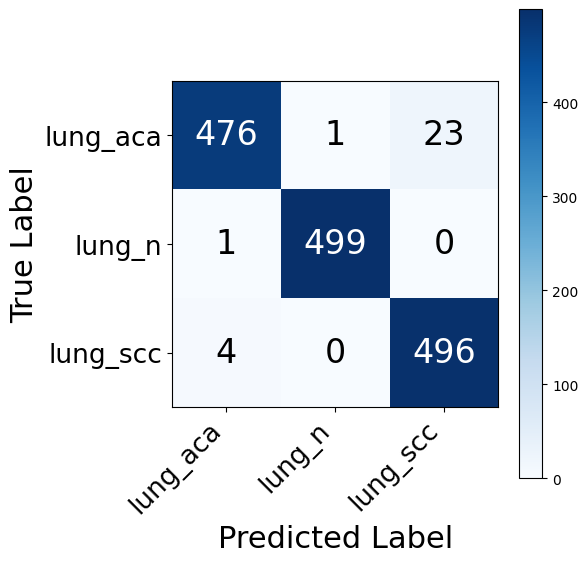

In [50]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# VGG16

In [51]:
from tensorflow.keras.applications import VGG16

In [52]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False


flatten = Flatten()(vgg16.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
vgg16_model = Model(inputs=vgg16.input, outputs=prediction)

# Print the model summary
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,170,755 (80.76 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [53]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
batch_size = 128

# VGG16 Training

In [55]:
history = vgg16_model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


2024-09-08 11:35:29.982031: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-08 11:35:30.281379: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.299524885s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0

11/94 ━━━━━━━━━━━━━━━━━━━━ 48s 583ms/step - accuracy: 0.1045 - loss: 95.9474

2024-09-08 11:38:31.114283: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[96,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-08 11:38:31.212749: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.098577098s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[96,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} 

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6077 - loss: 31.0240

W0000 00:00:1725795570.598414     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-09-08 11:40:13.447138: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[92,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[92,128,112,112]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-08 11:40:13.616202: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.169164706s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[92,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[92,128,112,112]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$c

94/94 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.6098 - loss: 30.8047 - val_accuracy: 0.9520 - val_loss: 0.4463
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 667ms/step - accuracy: 0.9124 - loss: 1.7418 - val_accuracy: 0.9560 - val_loss: 0.3404
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 660ms/step - accuracy: 0.9672 - loss: 0.1983 - val_accuracy: 0.9667 - val_loss: 0.1687
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 664ms/step - accuracy: 0.9868 - loss: 0.0544 - val_accuracy: 0.9673 - val_loss: 0.1713
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 661ms/step - accuracy: 0.9938 - loss: 0.0199 - val_accuracy: 0.9747 - val_loss: 0.1015


# VGG16 Evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.9838 - loss: 0.0653
test_loss, test accuracy [0.05850004032254219, 0.9833333492279053]


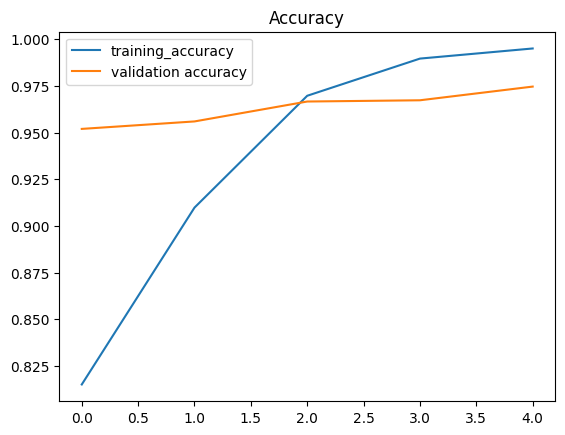

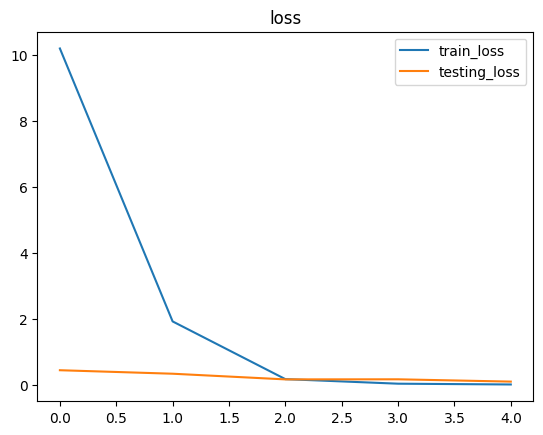

 1/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step

W0000 00:00:1725795938.236184     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 593ms/step


W0000 00:00:1725795944.755561     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[488   2  10]
 [  0 500   0]
 [ 13   0 487]]
Classification Report
              precision    recall  f1-score   support

         aca       0.97      0.98      0.98       500
           n       1.00      1.00      1.00       500
         scc       0.98      0.97      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [56]:
result = vgg16_model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

accuracy_curve(history)
loss_curve(history)
reports(vgg16_model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step


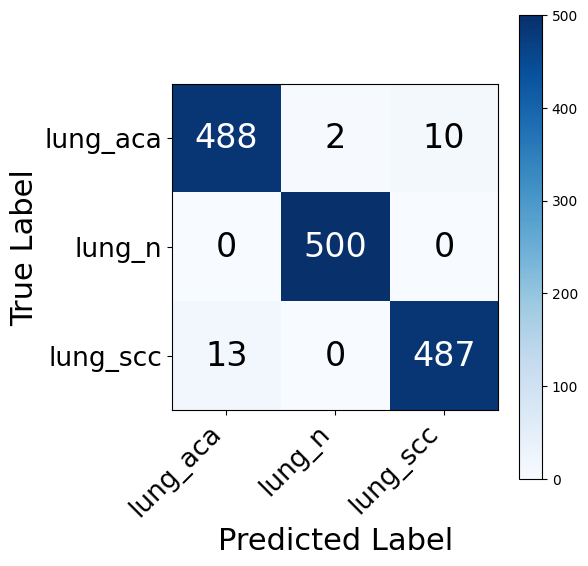

In [57]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = vgg16_model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# VGG19

In [58]:
from tensorflow.keras.applications import VGG19

In [59]:
vgg19=VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [60]:
for layer in vgg19.layers:
    layer.trainable = False

In [61]:
# Add new layers
flatten = Flatten()(vgg19.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

In [62]:
# Create the model
model = Model(inputs=vgg19.input, outputs=prediction)

# Print the model summary
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,89

 Total params: 26,480,451 (101.01 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [63]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# VGG19 training

In [64]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [65]:
history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


W0000 00:00:1725795962.397563     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/94 ━━━━━━━━━━━━━━━━━━━━ 9s 693ms/step - accuracy: 0.6286 - loss: 43.6742 

W0000 00:00:1725796018.854356     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.6564 - loss: 38.9994

W0000 00:00:1725796030.468474     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725796038.502370     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 816ms/step - accuracy: 0.6582 - loss: 38.7092 - val_accuracy: 0.8613 - val_loss: 1.9007
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 775ms/step - accuracy: 0.8413 - loss: 5.3473 - val_accuracy: 0.9447 - val_loss: 0.2241
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 773ms/step - accuracy: 0.9385 - loss: 0.4505 - val_accuracy: 0.9360 - val_loss: 0.4082
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 772ms/step - accuracy: 0.9308 - loss: 0.4647 - val_accuracy: 0.9253 - val_loss: 0.3012
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 775ms/step - accuracy: 0.9579 - loss: 0.1257 - val_accuracy: 0.9713 - val_loss: 0.0863


# VGG19 evaluation

In [66]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 671ms/step - accuracy: 0.9678 - loss: 0.0913
test_loss, test accuracy [0.0834919884800911, 0.9700000286102295]


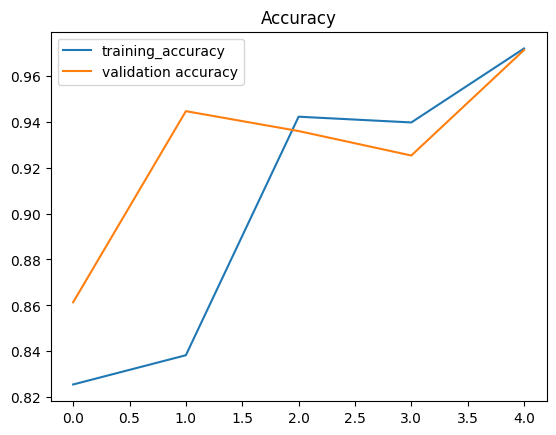

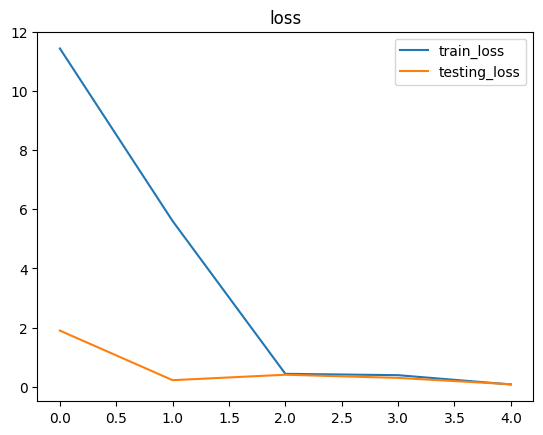

 1/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step

W0000 00:00:1725796358.153144     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 729ms/step


W0000 00:00:1725796366.166147     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[479   1  20]
 [  4 496   0]
 [ 20   0 480]]
Classification Report
              precision    recall  f1-score   support

         aca       0.95      0.96      0.96       500
           n       1.00      0.99      0.99       500
         scc       0.96      0.96      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [67]:
accuracy_curve(history)
loss_curve(history)
reports(model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step


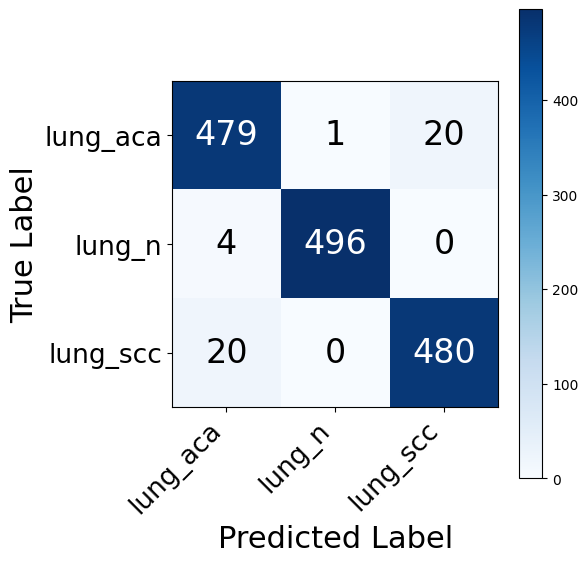

In [68]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# Mobilenet v2

In [69]:
from tensorflow.keras.applications import MobileNetV2

In [70]:
mobile=MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in mobile.layers:
    layer.trainable = False

# Add new layers
flatten = Flatten()(mobile.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)


model = Model(inputs=mobile.input, outputs=prediction)


model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 18,347,843 (69.99 MB)

 Trainable params: 16,089,859 (61.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [71]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# MobilenetV2 training

In [72]:
history = model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5
 1/94 ━━━━━━━━━━━━━━━━━━━━ 26:45 17s/step - accuracy: 0.2656 - loss: 1.2727

W0000 00:00:1725796396.253994     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/94 ━━━━━━━━━━━━━━━━━━━━ 27s 612ms/step - accuracy: 0.3734 - loss: 23.4879

W0000 00:00:1725796425.681612     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.5109 - loss: 15.7597

W0000 00:00:1725796451.460983     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 696ms/step - accuracy: 0.5128 - loss: 15.6548 - val_accuracy: 0.8200 - val_loss: 0.9535
Epoch 2/5


W0000 00:00:1725796461.024311     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 564ms/step - accuracy: 0.8491 - loss: 1.0893 - val_accuracy: 0.8140 - val_loss: 1.0895
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 552ms/step - accuracy: 0.8991 - loss: 0.4050 - val_accuracy: 0.9293 - val_loss: 0.1763
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 554ms/step - accuracy: 0.9262 - loss: 0.1793 - val_accuracy: 0.7900 - val_loss: 0.7440
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 567ms/step - accuracy: 0.8736 - loss: 0.4136 - val_accuracy: 0.8433 - val_loss: 0.4352


# Mobilenetv2 evaluation

In [73]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 504ms/step - accuracy: 0.7081 - loss: 0.9191
test_loss, test accuracy [0.48534858226776123, 0.8460000157356262]


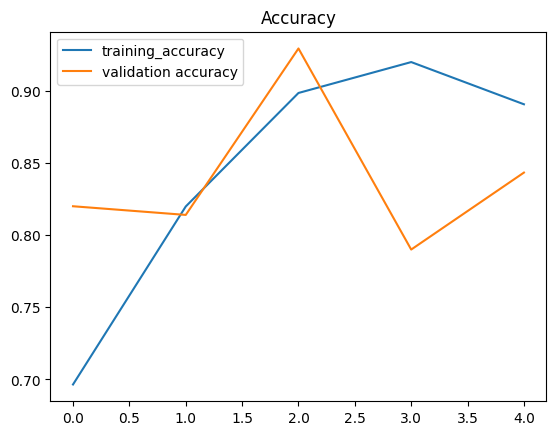

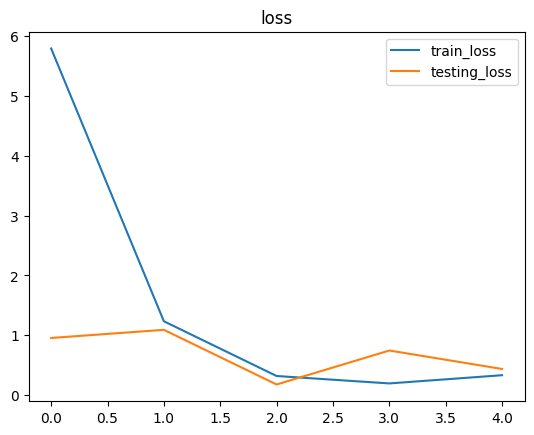

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step

W0000 00:00:1725796724.872631     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 753ms/step
Confusion Matrix
[[273  20 207]
 [  0 500   0]
 [  4   0 496]]
Classification Report
              precision    recall  f1-score   support

         aca       0.99      0.55      0.70       500
           n       0.96      1.00      0.98       500
         scc       0.71      0.99      0.82       500

    accuracy                           0.85      1500
   macro avg       0.88      0.85      0.84      1500
weighted avg       0.88      0.85      0.84      1500



W0000 00:00:1725796733.151463     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [74]:
accuracy_curve(history)
loss_curve(history)
reports(model,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step


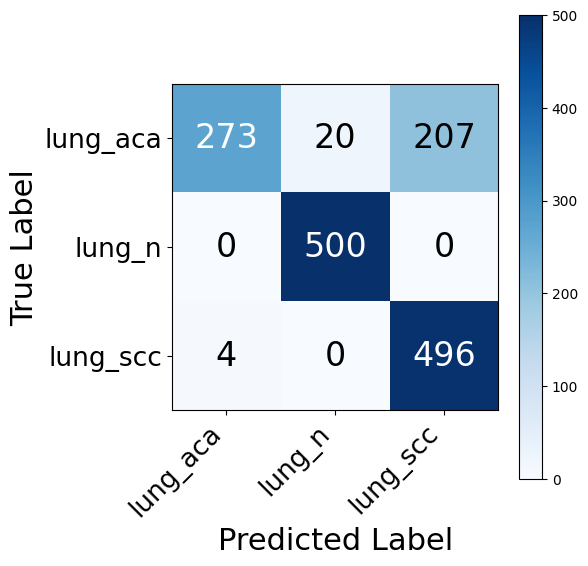

In [75]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = model.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()

# Inception v3

In [76]:
from tensorflow.keras.applications import InceptionV3

In [77]:
# Load the InceptionV3 model
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in inception.layers:
    layer.trainable = False

# Add new layers
flatten = Flatten()(inception.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the model
inception = Model(inputs=inception.input, outputs=prediction)

# Print the model summary
inception.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 34,943,523 (133.30 MB)

 Trainable params: 13,140,739 (50.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [78]:
# Compile the model
inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Inception Train

In [79]:
history = inception.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


W0000 00:00:1725796794.796249     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/94 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.4187 - loss: 406.0264  

W0000 00:00:1725796845.790283     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.4611 - loss: 275.7126

W0000 00:00:1725796878.819144     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.4617 - loss: 274.3077 - val_accuracy: 0.7567 - val_loss: 10.4046
Epoch 2/5


W0000 00:00:1725796911.311935     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 582ms/step - accuracy: 0.6826 - loss: 24.2042 - val_accuracy: 0.7427 - val_loss: 11.1160
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 618ms/step - accuracy: 0.7222 - loss: 10.2539 - val_accuracy: 0.8247 - val_loss: 3.6579
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 571ms/step - accuracy: 0.7980 - loss: 5.0216 - val_accuracy: 0.8067 - val_loss: 3.3820
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - accuracy: 0.8055 - loss: 3.4541 - val_accuracy: 0.7720 - val_loss: 2.8474


# Inception Evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 508ms/step - accuracy: 0.7169 - loss: 3.8102
test_loss, test accuracy [2.6126203536987305, 0.7839999794960022]


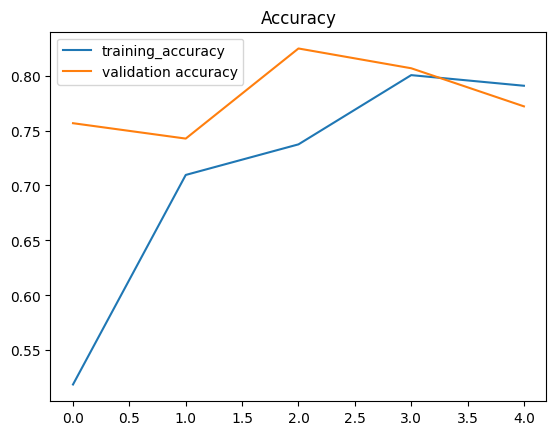

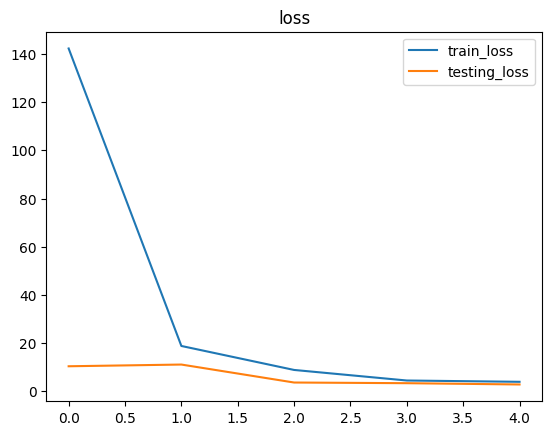

 1/12 ━━━━━━━━━━━━━━━━━━━━ 1:11 7s/step

W0000 00:00:1725797205.972504     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 964ms/step
Confusion Matrix
[[304 145  51]
 [  4 496   0]
 [108  16 376]]
Classification Report
              precision    recall  f1-score   support

         aca       0.73      0.61      0.66       500
           n       0.75      0.99      0.86       500
         scc       0.88      0.75      0.81       500

    accuracy                           0.78      1500
   macro avg       0.79      0.78      0.78      1500
weighted avg       0.79      0.78      0.78      1500



W0000 00:00:1725797216.579871     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [80]:
result = inception.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

accuracy_curve(history)
loss_curve(history)
reports(inception,test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 561ms/step


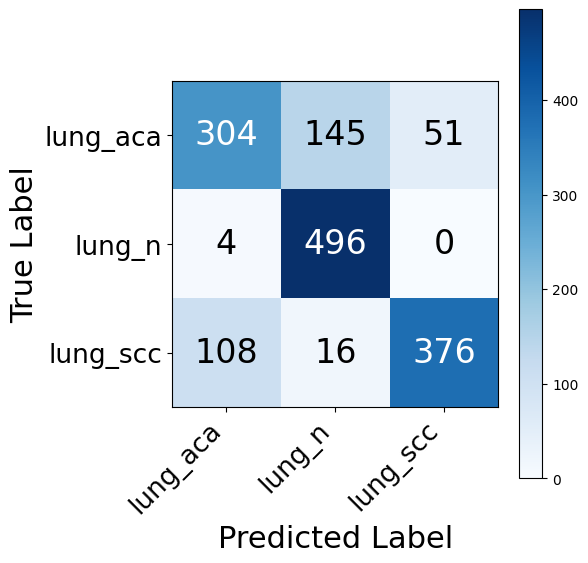

In [81]:
# Get true labels and predictions
y_true = test_set.classes
y_pred_prob = inception.predict(test_set, batch_size=128)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using imshow
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust size if needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar for better visualization
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for axes
class_names = list(test_set.class_indices.keys())
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=19)

# Manually annotate the confusion matrix with larger text inside the boxes
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=24)  # Adjust fontsize here

# Set font size for axes labels
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)

# Show the plot
plt.tight_layout()
plt.show()